In [ ]:
%matplotlib inline

In [ ]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.fft import rfft, rfftfreq
from scipy.signal import argrelmin
from tqdm.notebook import tqdm

In [ ]:
from types import SimpleNamespace

import scipy.constants

###################################################################
# Units
# Length : nm
# Energy : meV
# Current : nA
# Temperature : K

constants = SimpleNamespace(
    hbar=scipy.constants.hbar,
    m_e=scipy.constants.m_e,
    eV=scipy.constants.eV,
    e=scipy.constants.e,
    meV=scipy.constants.eV * 1e-3,
    k_B=scipy.constants.k / (scipy.constants.eV * 1e-3),
    mu_B=scipy.constants.physical_constants["Bohr magneton"][0]
    / (scipy.constants.eV * 1e-3),
    current_unit=scipy.constants.k * scipy.constants.e / scipy.constants.hbar * 1e9,
)

In [ ]:
plt.style.use("../../sans_style.mplstyle")
plt.close("all")


pd_cmap = mpl.colors.ListedColormap(
    ["darkorange", "gold", "lightgreen", "lightseagreen"]
)
line_colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]


def add_tl_label(ax, text, color=[1, 1, 1, 0.90]):
    ax.text(
        0.03,
        0.96,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
    )

In [ ]:
simname = "Fig2"

ds = xr.open_dataset(f"./output/{simname}/{simname}.nc")

ws = ds["ws"]
a_N, b_N, theta_N, k = ws.shape

a_ax = ds.coords["a"].to_numpy()
b_ax = ds.coords["b"].to_numpy()

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")

theta_ax = ds.coords["theta"].to_numpy()
theta_N = theta_ax.shape[0]
dtheta = theta_ax[1] - theta_ax[0]

In [ ]:
a_label = r"$h_\mathrm{all} / \Delta$"
b_label = r"$\mu_C / \Delta$"

Delta_0 = 0.250
a_scale = Delta_0
b_scale = Delta_0

In [ ]:
def logcosh(x):
    ax = np.abs(x)
    return ax if ax > 2 else np.log(2 * np.cosh(x))


logcosh = np.frompyfunc(logcosh, 1, 1)

In [ ]:
# Set the temperature
T = 20e-3  # mK

f = -(constants.k_B * T) * logcosh(ws / (2 * constants.k_B * T))
F = np.sum(f, axis=-1)

F.name = "F"

In [ ]:
arm = argrelmin(F.to_numpy(), axis=-1, order=1, mode="wrap")

mins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]
vmins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]

for n in range(len(arm[0])):
    i = arm[0][n]
    j = arm[1][n]
    n = arm[2][n]

    mins_list[i][j].append(theta_ax[n])
    vmins_list[i][j].append(F[i, j, n])

In [ ]:
pd = np.zeros((a_N, b_N)) * np.nan
pdm = np.zeros((a_N, b_N)) * np.nan
pdf = np.zeros((a_N, b_N)) * np.nan

for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):

    if len(mins_list[i][j]) == 1:
        if abs(mins_list[i][j][0]) < abs(mins_list[i][j][0] - np.pi):
            pd[i][j] = 0
        else:
            pd[i][j] = 3.14

    elif len(mins_list[i][j]) == 2:
        vmmin = np.argmin(vmins_list[i][j])
        mmin = mins_list[i][j][vmmin]

        if abs(mmin) < abs(mmin - np.pi):
            pd[i][j] = 3.14 / 3
        else:
            pd[i][j] = 2 * 3.14 / 3

    else:
        pd[i][j] = np.mean(mins_list[i][j])
    pdm[i][j] = np.mean(mins_list[i][j])
    pdf[i][j] = mins_list[i][j][0]

  0%|          | 0/14641 [00:00<?, ?it/s]

In [ ]:
_I = (np.roll(F.to_numpy(), -1, axis=-1) - F.to_numpy()) / dtheta
_I *= 2 * constants.e / constants.hbar * constants.meV * 1e9

_I_c = np.zeros((a_N, b_N))
for i, j in np.ndindex(a_N, b_N):
    _I_c[i, j] = _I[i, j, np.argmax(np.abs(_I[i, j, : theta_N // 2]), axis=-1)]

I = xr.zeros_like(F)
I[:, :, :] = _I

I_c = xr.DataArray(_I_c, dims=("a", "b"), coords={"a": a_ax, "b": b_ax})

I_0 = 2 * constants.e * Delta_0 / constants.hbar * constants.meV * 1e9

In [ ]:
N = F.shape[-1]

ks = rfftfreq(N, 1 / N)
F_k = 2.0 / N * rfft(F)
cF_k = +F_k.real
sF_k = -F_k.imag

In [ ]:
a_coord = np.argmin(abs(a_ax-0.5*Delta_0))
b_coord = np.argmin(abs(b_ax-15.5*Delta_0))

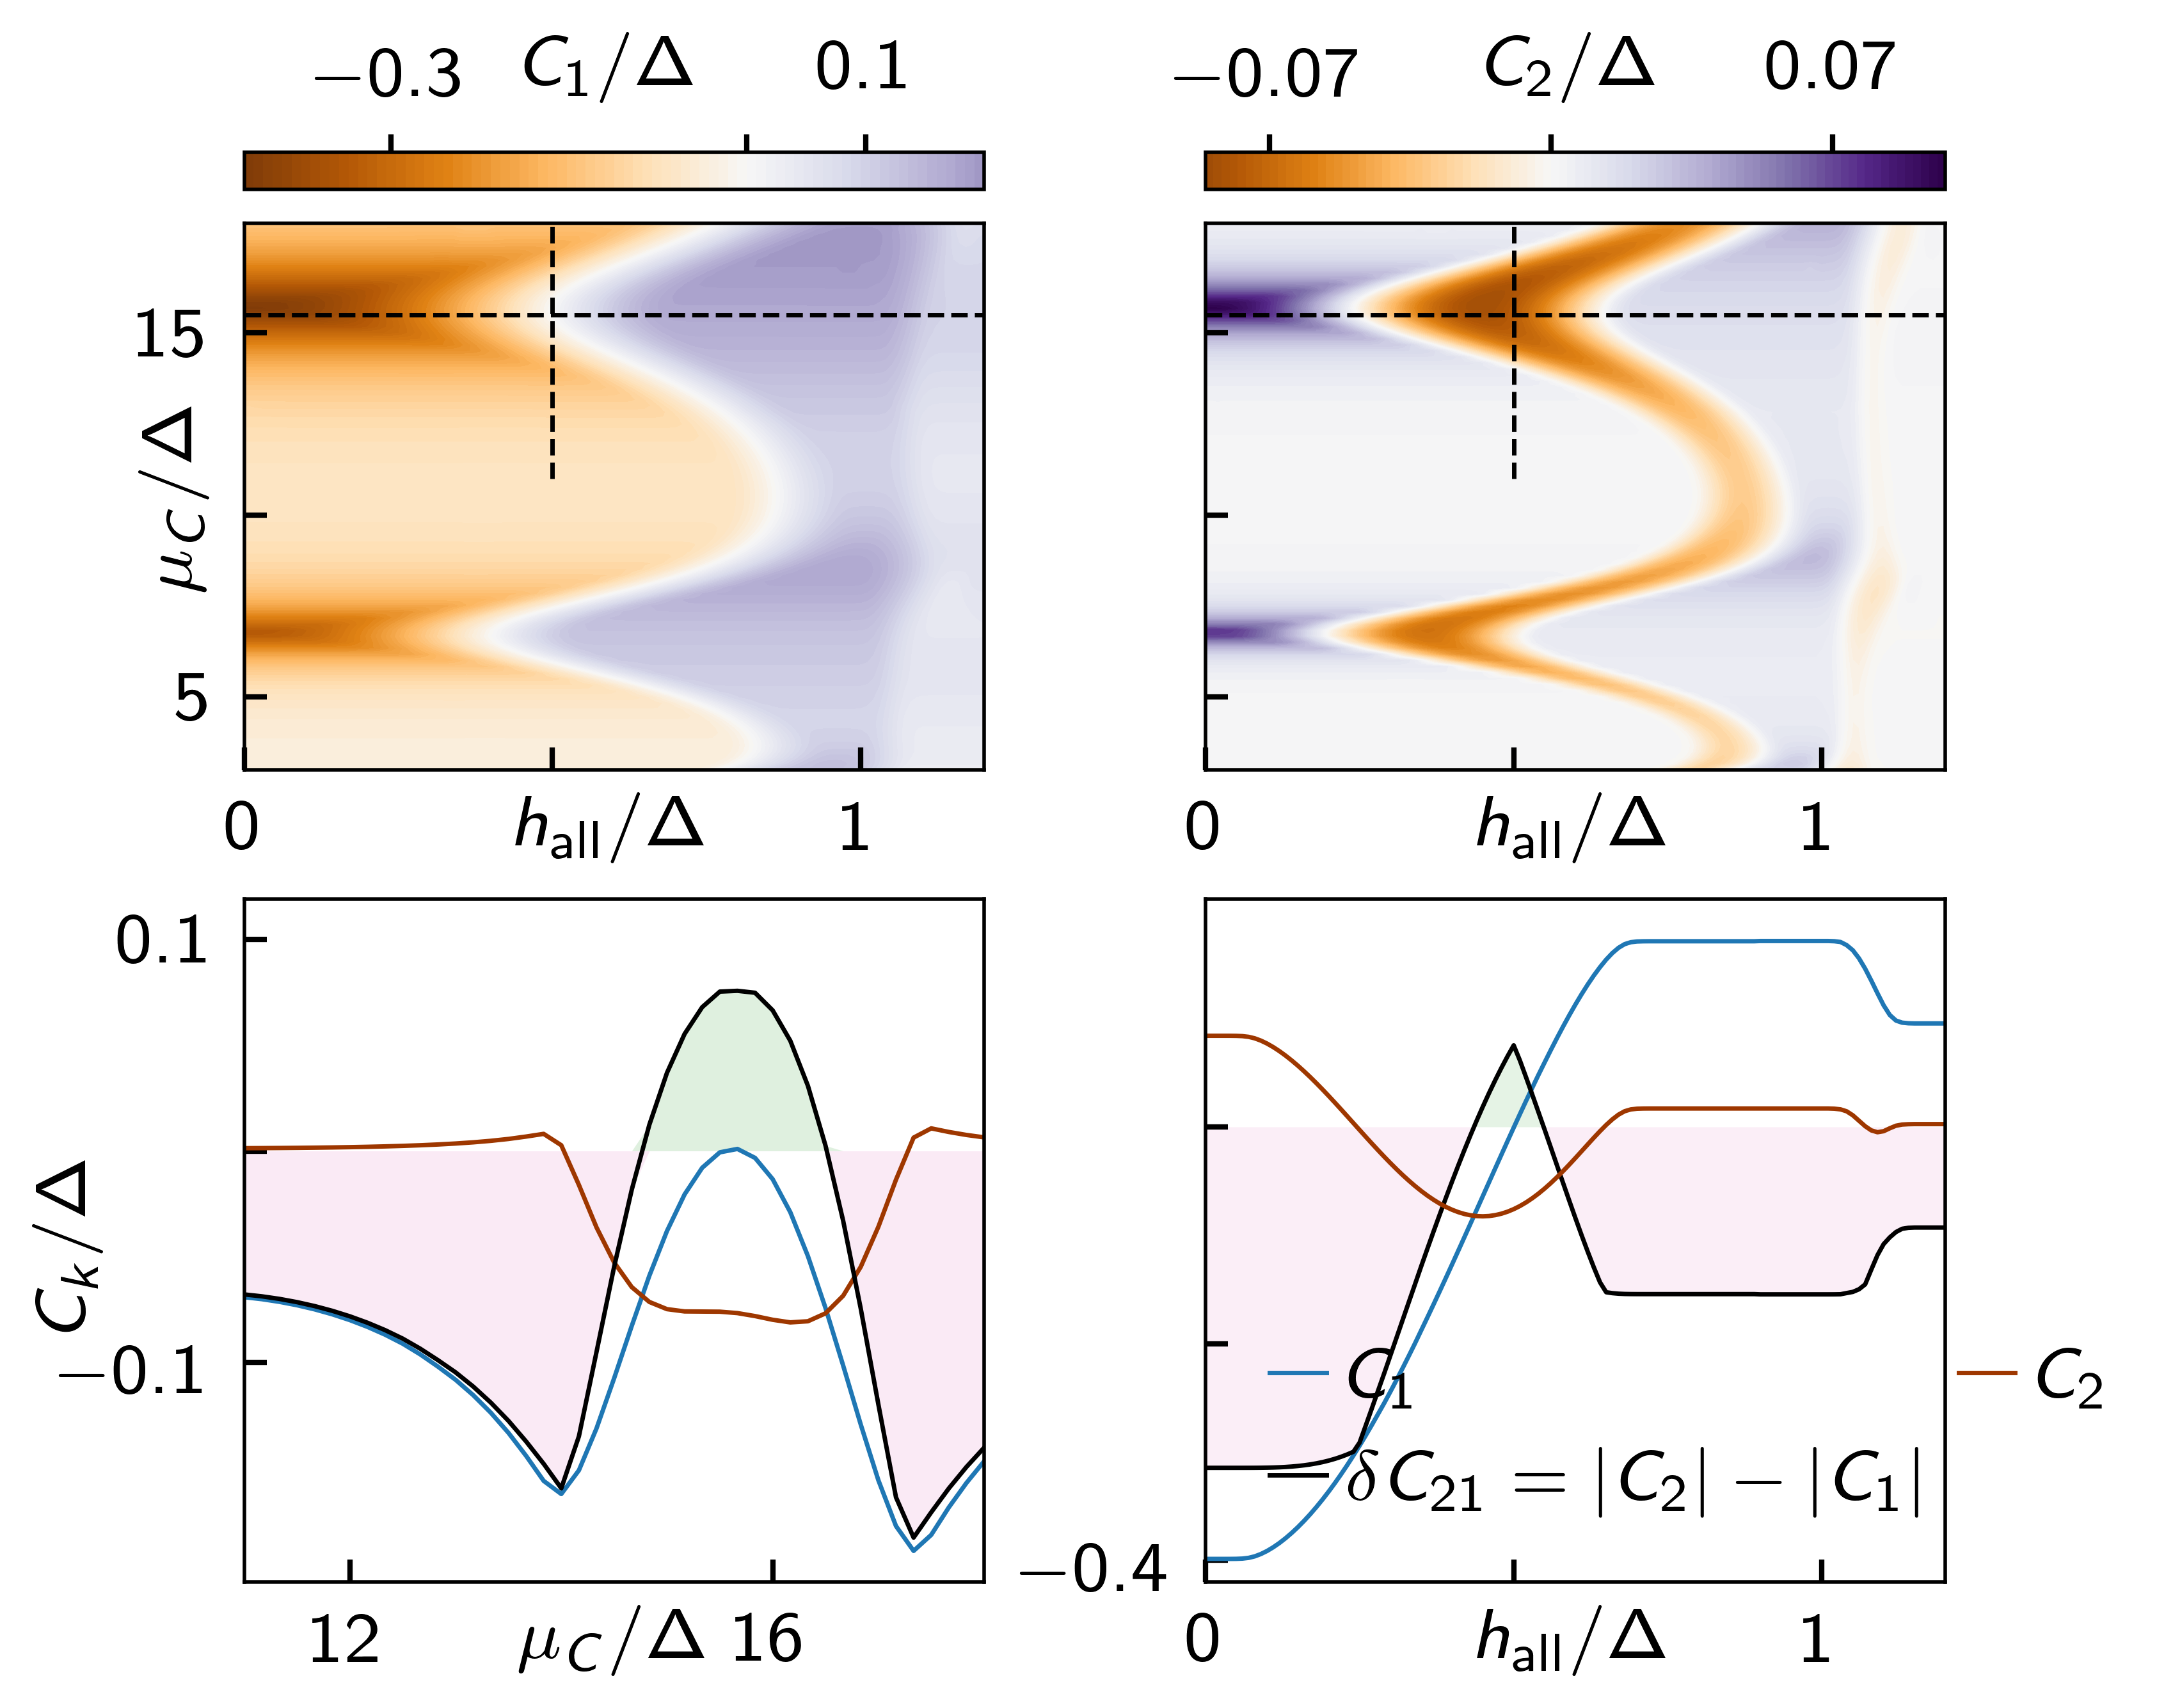

In [ ]:
fig, ((ax3, ax4), (ax5, ax6)) = plt.subplots(
    dpi=1000, figsize=(3.375, 3.375 * 0.8), ncols=2, nrows=2
)

# ax1.set_rasterization_zorder(0)
# ax2.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)
ax4.set_rasterization_zorder(0)

# levels = np.linspace(0, 3.2, 5)

# im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

# cbar1 = fig.colorbar(im, ax=ax1)
# cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
# cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
# cbar1.ax.tick_params(length=0)

# im = ax2.contourf(
#     a / a_scale,
#     b / b_scale,
#     I_c / I_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(),
#     cmap="RdBu_r",
#     zorder=-30,
# )
# cbar2 = fig.colorbar(im, ax=ax2)
# cbar2.set_ticks([np.around(I_c.min() / I_0, decimals=2), np.around(I_c.max() / I_0, decimals=2)])
# cbar2.ax.tick_params(length=0)
# cbar2.set_label(r"$I_c / I_0$", labelpad=-15)
# cbar2.ax.tick_params(length=0)


im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 1] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar3 = fig.colorbar(im3, ax=ax3, location="top")
cbar3.set_ticks([-0.3, 0, 0.1], labels=[r"$-0.3$", "", r"$0.1$"])
cbar3.ax.tick_params(length=2, direction="out")
cbar3.set_label(r"$C_1 / \Delta$", labelpad=-5)

im4 = ax4.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 2] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar4 = fig.colorbar(im4, ax=ax4, location="top")
cbar4.set_ticks([-0.07, 0, 0.07], labels=[r"$-0.07$", "", r"$0.07$"])
cbar4.ax.tick_params(length=2, direction="out")
cbar4.set_label(r"$C_2 / \Delta$", labelpad=-5)

ax3.set_ylim(3, 18)
ax4.set_ylim(3, 18)

ax3.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
ax4.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])

ax3.set_yticks([5, 10, 15], labels=[r"$5$", r"", r"$15$"])
ax4.set_yticks([5, 10, 15], labels=[])

ax3.set_xlabel(a_label, labelpad=-8)
ax3.set_ylabel(b_label, labelpad=-8)

ax4.set_xlabel(a_label, labelpad=-8)
# ax4.set_ylabel(b_label)

ax3.hlines(
    b_ax[b_coord] / b_scale,
    a_ax.min() / a_scale,
    a_ax.max() / a_scale,
    colors="k",
    linestyles="--",
)
ax4.hlines(
    b_ax[b_coord] / b_scale,
    a_ax.min() / a_scale,
    a_ax.max() / a_scale,
    colors="k",
    linestyles="--",
)
ax3.vlines(a_ax[a_coord] / a_scale, 11, 18, colors="k", linestyles="--")
ax4.vlines(a_ax[a_coord] / a_scale, 11, 18, colors="k", linestyles="--")

##########################
diffabs = np.abs(cF_k[:, :, 2]) - np.abs(cF_k[:, :, 1])

ax5.plot(
    b[0, :] / b_scale, (cF_k[a_coord, :, 1]) / Delta_0, "-", label="$C_1$",
)
ax5.plot(
    b[0, :] / b_scale,
    (cF_k[a_coord, :, 2]) / Delta_0,
    "-",
    color="#9e3700",
    label="$C_2$",
)
ax5.plot(
    b[0, :] / b_scale,
    (np.abs(cF_k[a_coord, :, 2]) - np.abs(cF_k[a_coord, :, 1])) / Delta_0,
    "-k",
    label="$|C_2|-|C_1|$",
)

# ax5.fill_between(
#     x =  b[0, :] / b_scale,
#     y1 =  (cF_k[a_coord, :, 1]) / Delta_0,
#     y2 = 0,
#     color='C0',
#     alpha=0.2,
#     linewidth=0,
# )
# ax5.fill_between(
#     x =  b[0, :] / b_scale,
#     y1 =(cF_k[a_coord, :, 2]) / Delta_0,
#     y2 = 0,
#     color='C1',
#     alpha=0.2,
#     linewidth=0,
# )
ax5.fill_between(
    x=b[0, :] / b_scale,
    y1=diffabs[a_coord, :,] * (diffabs[a_coord, :,] >= 0) / Delta_0,
    y2=0,
    color="C2",
    alpha=0.15,
    linewidth=0,
)
ax5.fill_between(
    x=b[0, :] / b_scale,
    y1=diffabs[a_coord, :,] * (diffabs[a_coord, :,] <= 0) / Delta_0,
    y2=0,
    color="C6",
    alpha=0.15,
    linewidth=0,
)


ax5.set_xticks([12, 16], [r"$12$", r"$16$"])
ax5.set_xlabel(b_label, labelpad=-8)

ax5.set_ylabel(r"$C_k / \Delta$", labelpad=-5)
ax5.set_yticks([-0.1, 0.0, 0.1], labels=[r"$-0.1$", "", r"$0.1$"])
# ax5.legend(ncol=4)
# ax5.set_ylim(-0.01, 0.25)
ax5.set_xlim(11, 18)

###

ax6.plot(
    a[:, b_coord] / a_scale, (cF_k[:, b_coord, 1]) / Delta_0, "-", label="$C_1$",
)

ax6.plot(
    a[:, b_coord] / a_scale,
    (np.abs(cF_k[:, b_coord, 2]) - np.abs(cF_k[:, b_coord, 1])) / Delta_0,
    "-k",
    label="$\delta C_{21}$",
)
ax6.plot(
    a[:, b_coord] / a_scale,
    (cF_k[:, b_coord, 2]) / Delta_0,
    "-",
    color="#9e3700",
    label="$C_2$",
)
# ax6.plot(
#     a[:, b_coord] / a_scale,
#     (cF_k[:, b_coord, 3]) / Delta_0,
#     "-",
#     label="$C_3$",
# )
# ax6.plot(
#     a[:, b_coord] / a_scale,
#     (cF_k[:, b_coord, 4]) / Delta_0,
#     "-",
#     label="$C_4$",
# )


# ax6.fill_between(
#     x = a[:, b_coord] / a_scale,
#     y1 = (cF_k[:, b_coord, 1] )/ Delta_0,
#     y2 = 0,
#     color='C0',
#     alpha=0.2,
#     linewidth=0,
# )
# ax6.fill_between(
#     x = a[:, b_coord] / a_scale,
#     y1 = (cF_k[:, b_coord, 2] )/ Delta_0,
#     y2 = 0,
#     color='C1',
#     alpha=0.2,
#     linewidth=0,
# )
ax6.fill_between(
    x=a[:, b_coord] / a_scale,
    y1=diffabs[:, b_coord] * (diffabs[:, b_coord] >= 0) / Delta_0,
    y2=0,
    color="C2",
    alpha=0.12,
    linewidth=0,
)
ax6.fill_between(
    x=a[:, b_coord] / a_scale,
    y1=diffabs[:, b_coord] * (diffabs[:, b_coord] <= 0) / Delta_0,
    y2=0,
    color="C6",
    alpha=0.12,
    linewidth=0,
)

# ax6.plot(
#     a[:, b_coord] / a_scale,
#     2*(cF_k[:, b_coord, 2])/ Delta_0,
#     "-",
#     label="$2C_2$",
# )
# ax6.plot(
#     a[:, b_coord] / a_scale,
#     2*(cF_k[:, b_coord, 3]) / Delta_0,
#     "-",
#     label="$2C_3$",
# )
# ax6.plot(
#     a[:, b_coord] / a_scale,
#     2*(cF_k[:, b_coord, 4]) / Delta_0,
#     "-",
#     label="$2C_4$",
# )

ax6.set_xticks([0, 0.5, 1])
ax6.set_xticklabels([r"$0$", r"", r"$1$"])
ax6.set_xlabel(a_label, labelpad=-8)
ax6.set_xlim(0, 1.2)

# ax6.set_ylabel(r"$C_k / \Delta$", labelpad=-8)
ax6.set_yticks([-0.4, -0.2, 0, 0.3], labels=[r"$-0.4$", "", "", r"$0.2$"])
ax6.set_ylim(-0.42, 0.21)

# ax6.hlines([0], -1, 1.5, colors="k", linestyles="--")
ax6.legend(ncol=2)


fig.tight_layout(pad=0.5)
fig.savefig("Fig3-dot.svg")

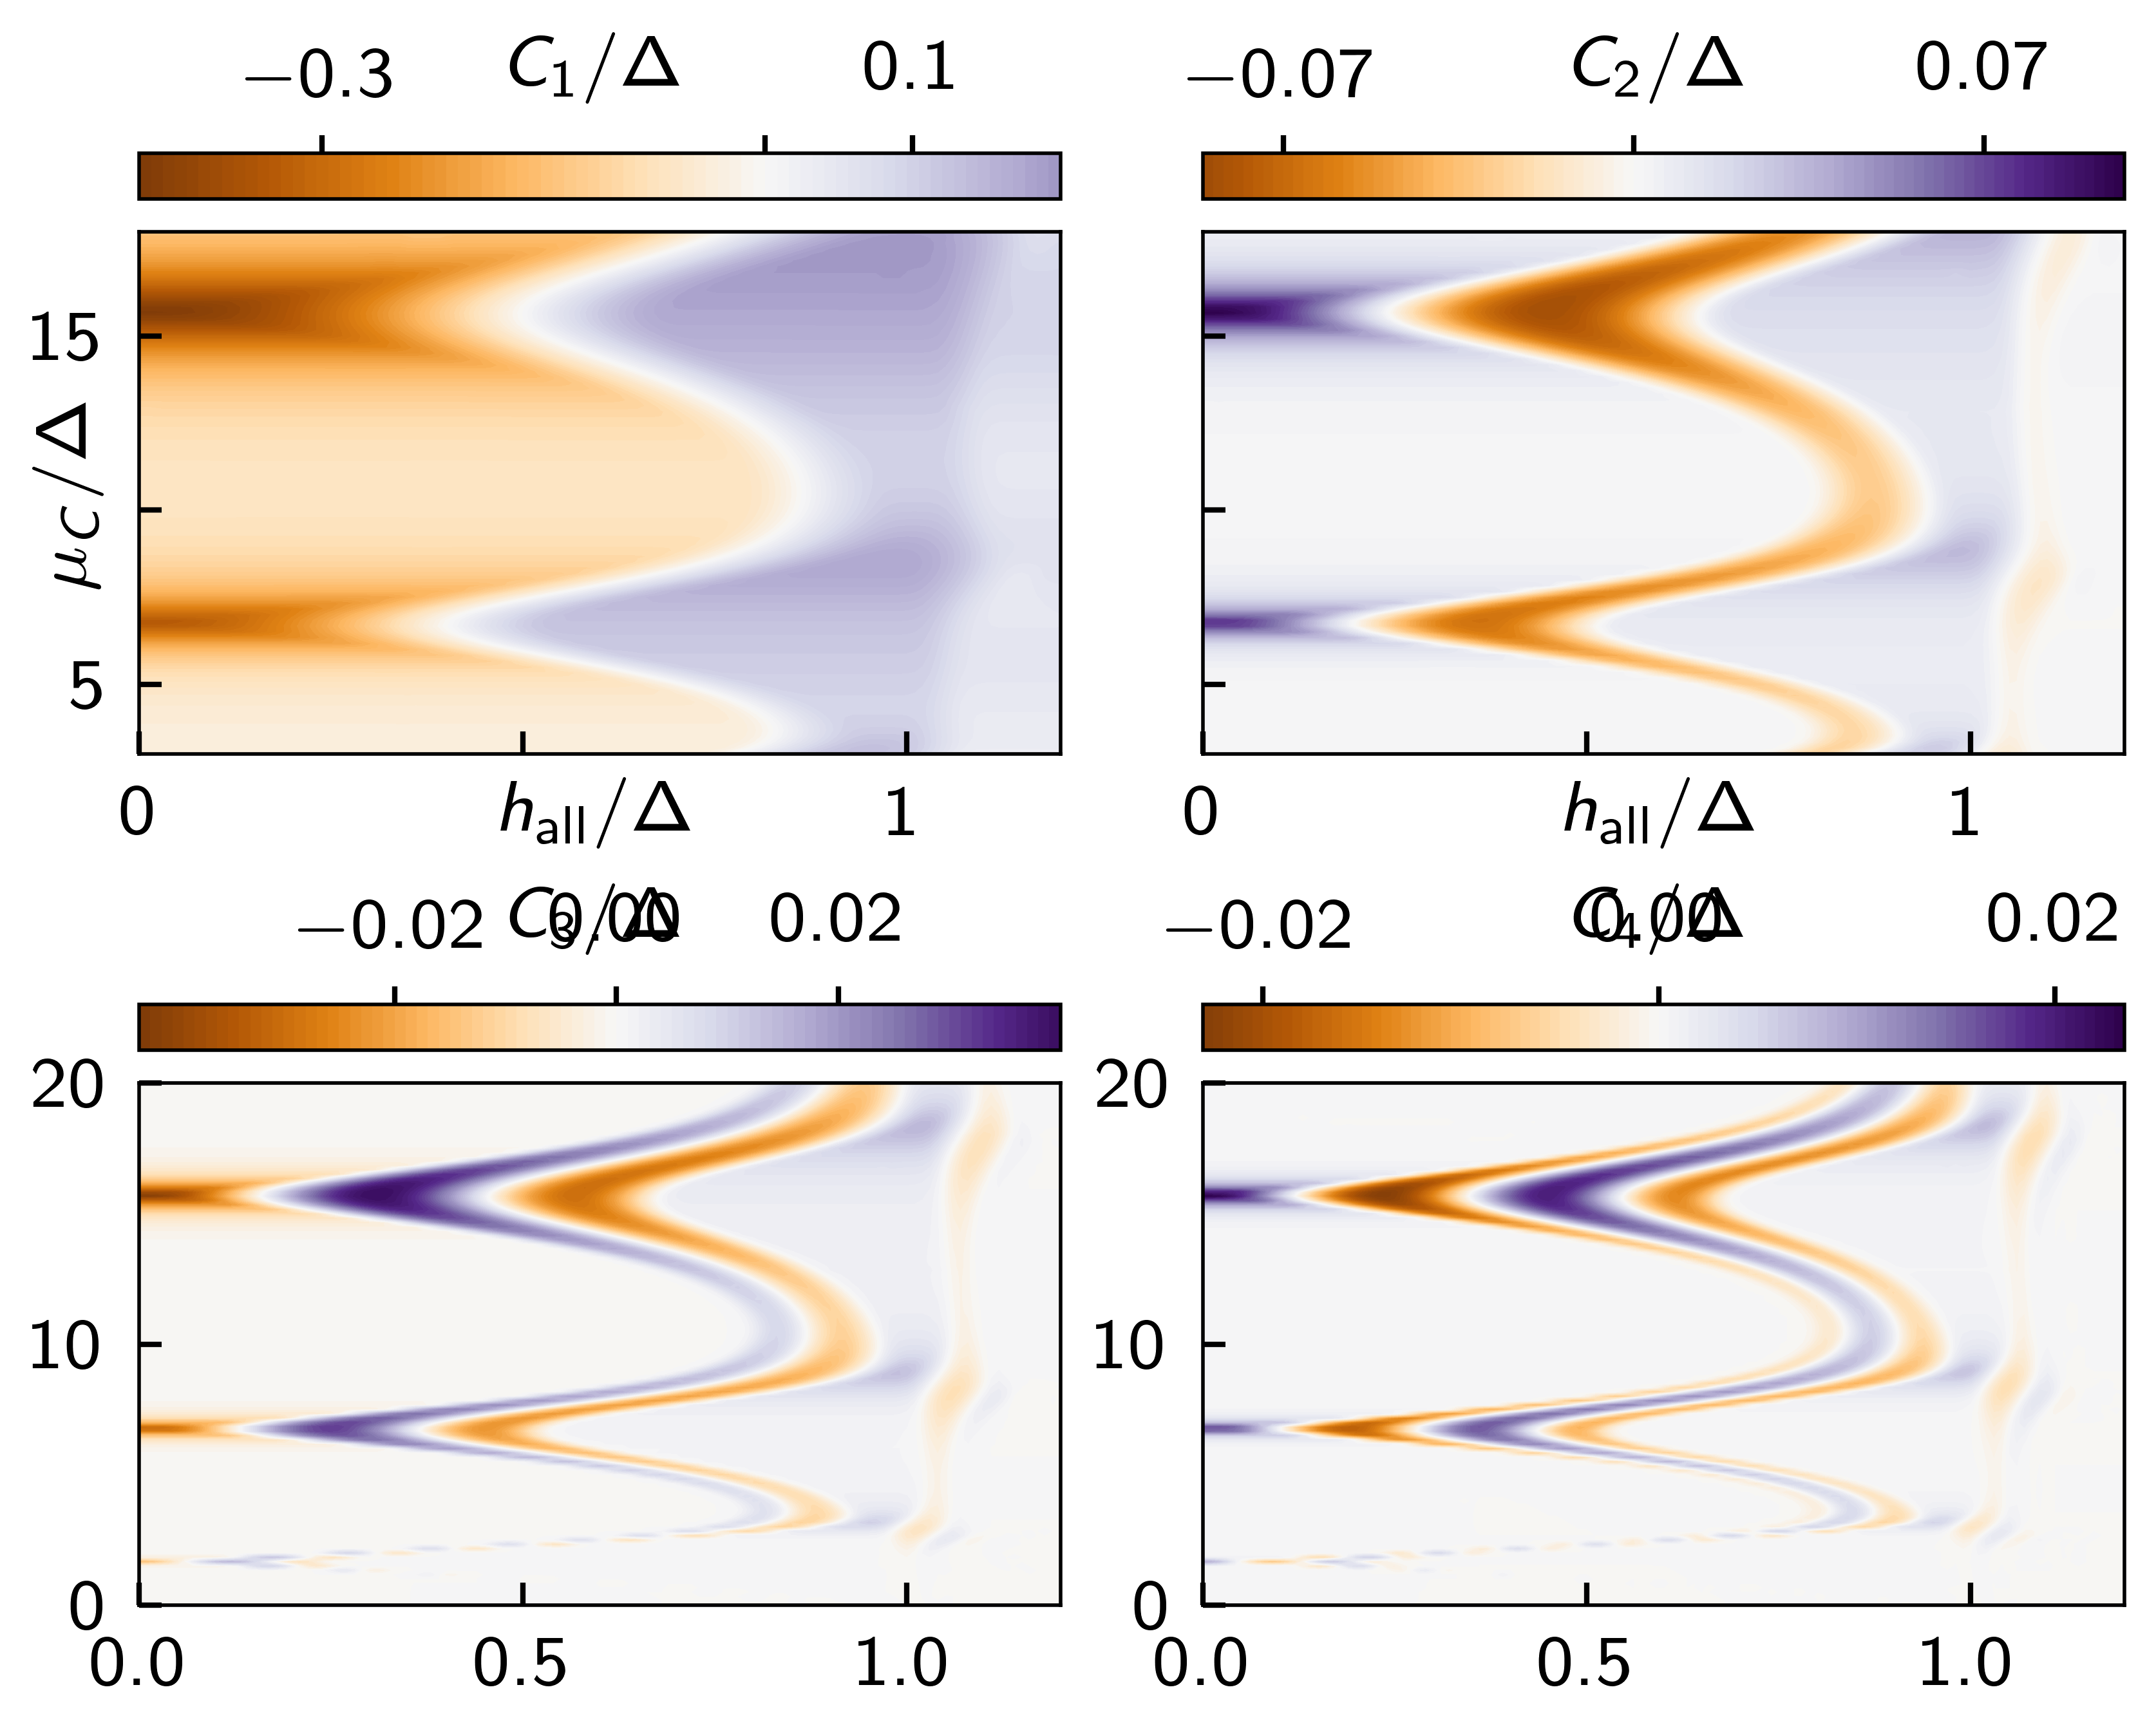

In [22]:
fig, ((ax3, ax4), (ax5, ax6)) = plt.subplots(
    dpi=1000, figsize=(3.375, 3.375 * 0.8), ncols=2, nrows=2
)

# ax1.set_rasterization_zorder(0)
# ax2.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)
ax4.set_rasterization_zorder(0)

# levels = np.linspace(0, 3.2, 5)

# im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

# cbar1 = fig.colorbar(im, ax=ax1)
# cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
# cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
# cbar1.ax.tick_params(length=0)

# im = ax2.contourf(
#     a / a_scale,
#     b / b_scale,
#     I_c / I_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(),
#     cmap="RdBu_r",
#     zorder=-30,
# )
# cbar2 = fig.colorbar(im, ax=ax2)
# cbar2.set_ticks([np.around(I_c.min() / I_0, decimals=2), np.around(I_c.max() / I_0, decimals=2)])
# cbar2.ax.tick_params(length=0)
# cbar2.set_label(r"$I_c / I_0$", labelpad=-15)
# cbar2.ax.tick_params(length=0)


im3 = ax3.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 1] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar3 = fig.colorbar(im3, ax=ax3, location="top")
cbar3.set_ticks([-0.3, 0, 0.1], labels=[r"$-0.3$", "", r"$0.1$"])
cbar3.ax.tick_params(length=2, direction="out")
cbar3.set_label(r"$C_1 / \Delta$", labelpad=-5)

im4 = ax4.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 2] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar4 = fig.colorbar(im4, ax=ax4, location="top")
cbar4.set_ticks([-0.07, 0, 0.07], labels=[r"$-0.07$", "", r"$0.07$"])
cbar4.ax.tick_params(length=2, direction="out")
cbar4.set_label(r"$C_2 / \Delta$", labelpad=-5)

ax3.set_ylim(3, 18)
ax4.set_ylim(3, 18)

ax3.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
ax4.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])

ax3.set_yticks([5, 10, 15], labels=[r"$5$", r"", r"$15$"])
ax4.set_yticks([5, 10, 15], labels=[])

ax3.set_xlabel(a_label, labelpad=-8)
ax3.set_ylabel(b_label, labelpad=-8)

ax4.set_xlabel(a_label, labelpad=-8)
# ax4.set_ylabel(b_label)



im5 = ax5.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 3] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar5 = fig.colorbar(im5, ax=ax5, location="top")
cbar5.set_ticks([-0.02, 0, 0.02])
cbar5.ax.tick_params(length=2, direction="out")
cbar5.set_label(r"$C_3 / \Delta$", labelpad=-5)

im6 = ax6.contourf(
    a / a_scale,
    b / b_scale,
    cF_k[:, :, 4] / Delta_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(0),
    cmap="PuOr",
    zorder=-30,
)
cbar6= fig.colorbar(im6, ax=ax6, location="top")
cbar6.set_ticks([-0.02, 0, 0.02])
cbar6.ax.tick_params(length=2, direction="out")
cbar6.set_label(r"$C_4 / \Delta$", labelpad=-5)

# ax3.set_ylim(3, 18)
# ax4.set_ylim(3, 18)

# ax3.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])
# ax4.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])

# ax3.set_yticks([5, 10, 15], labels=[r"$5$", r"", r"$15$"])
# ax4.set_yticks([5, 10, 15], labels=[])

# ax3.set_xlabel(a_label, labelpad=-8)
# ax3.set_ylabel(b_label, labelpad=-8)

# ax4.set_xlabel(a_label, labelpad=-8)
# # ax4.set_ylabel(b_label)




fig.tight_layout(pad=0.5)

(-0.05, 0.05)

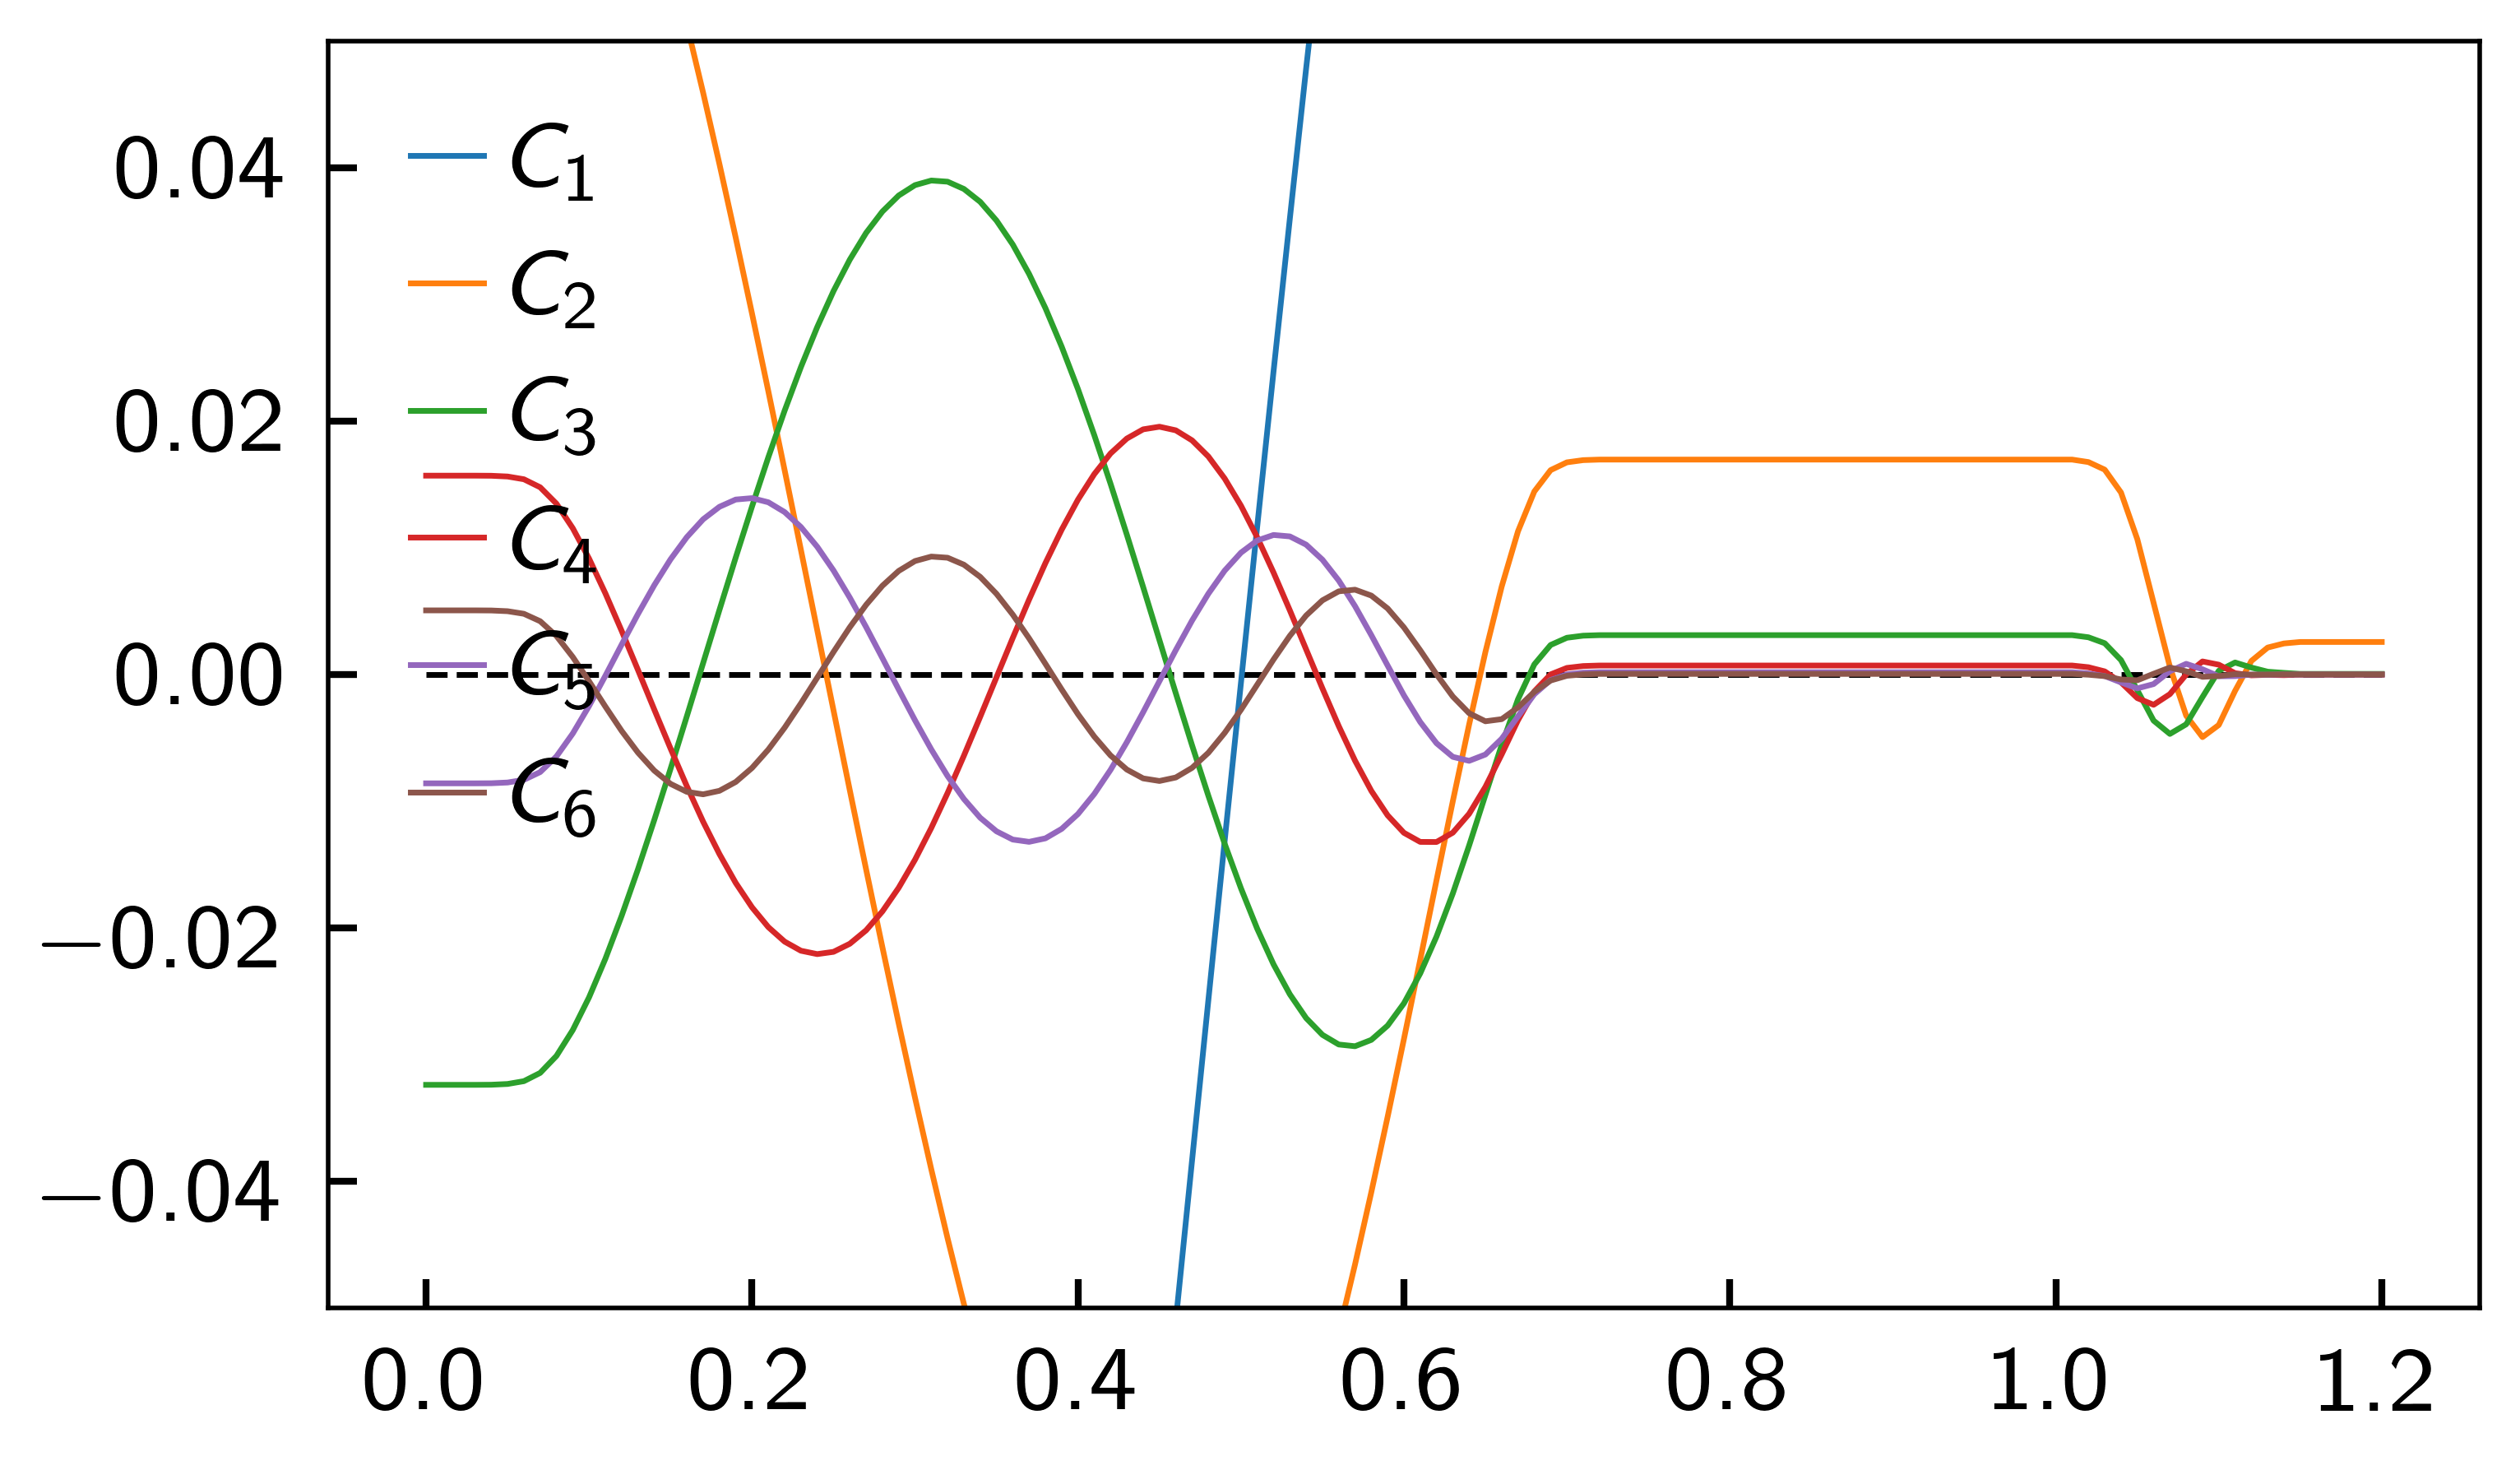

In [31]:
fig, ax = plt.subplots()
ax.plot(
    a[:, b_coord] / a_scale,
    0*cF_k[:, b_coord, 1] / Delta_0,
    '--k'
)
ax.plot(
    a[:, b_coord] / a_scale,
    cF_k[:, b_coord, 1] / Delta_0,
    '-',
    label=r'$C_1$'
)
ax.plot(
    a[:, b_coord] / a_scale,
    cF_k[:, b_coord, 2] / Delta_0,
    '-',
    label=r'$C_2$'
)
ax.plot(
    a[:, b_coord] / a_scale,
    cF_k[:, b_coord, 3] / Delta_0,
    '-',
    label=r'$C_3$'
)
ax.plot(
    a[:, b_coord] / a_scale,
    cF_k[:, b_coord, 4] / Delta_0,
    '-',
    label=r'$C_4$'
)
ax.plot(
    a[:, b_coord] / a_scale,
    cF_k[:, b_coord, 5] / Delta_0,
    '-',
    label=r'$C_5$'
)
ax.plot(
    a[:, b_coord] / a_scale,
    cF_k[:, b_coord, 6] / Delta_0,
    '-',
    label=r'$C_6$'
)
ax.legend()
ax.set_ylim(-0.05, 0.05)